In [1]:
import numpy as np
import pandas as pd
from format_data import *
from preprocess import *
from plots import *
from utils import *

In [2]:
Db=pd.read_excel('table.xlsx')

# Supervised

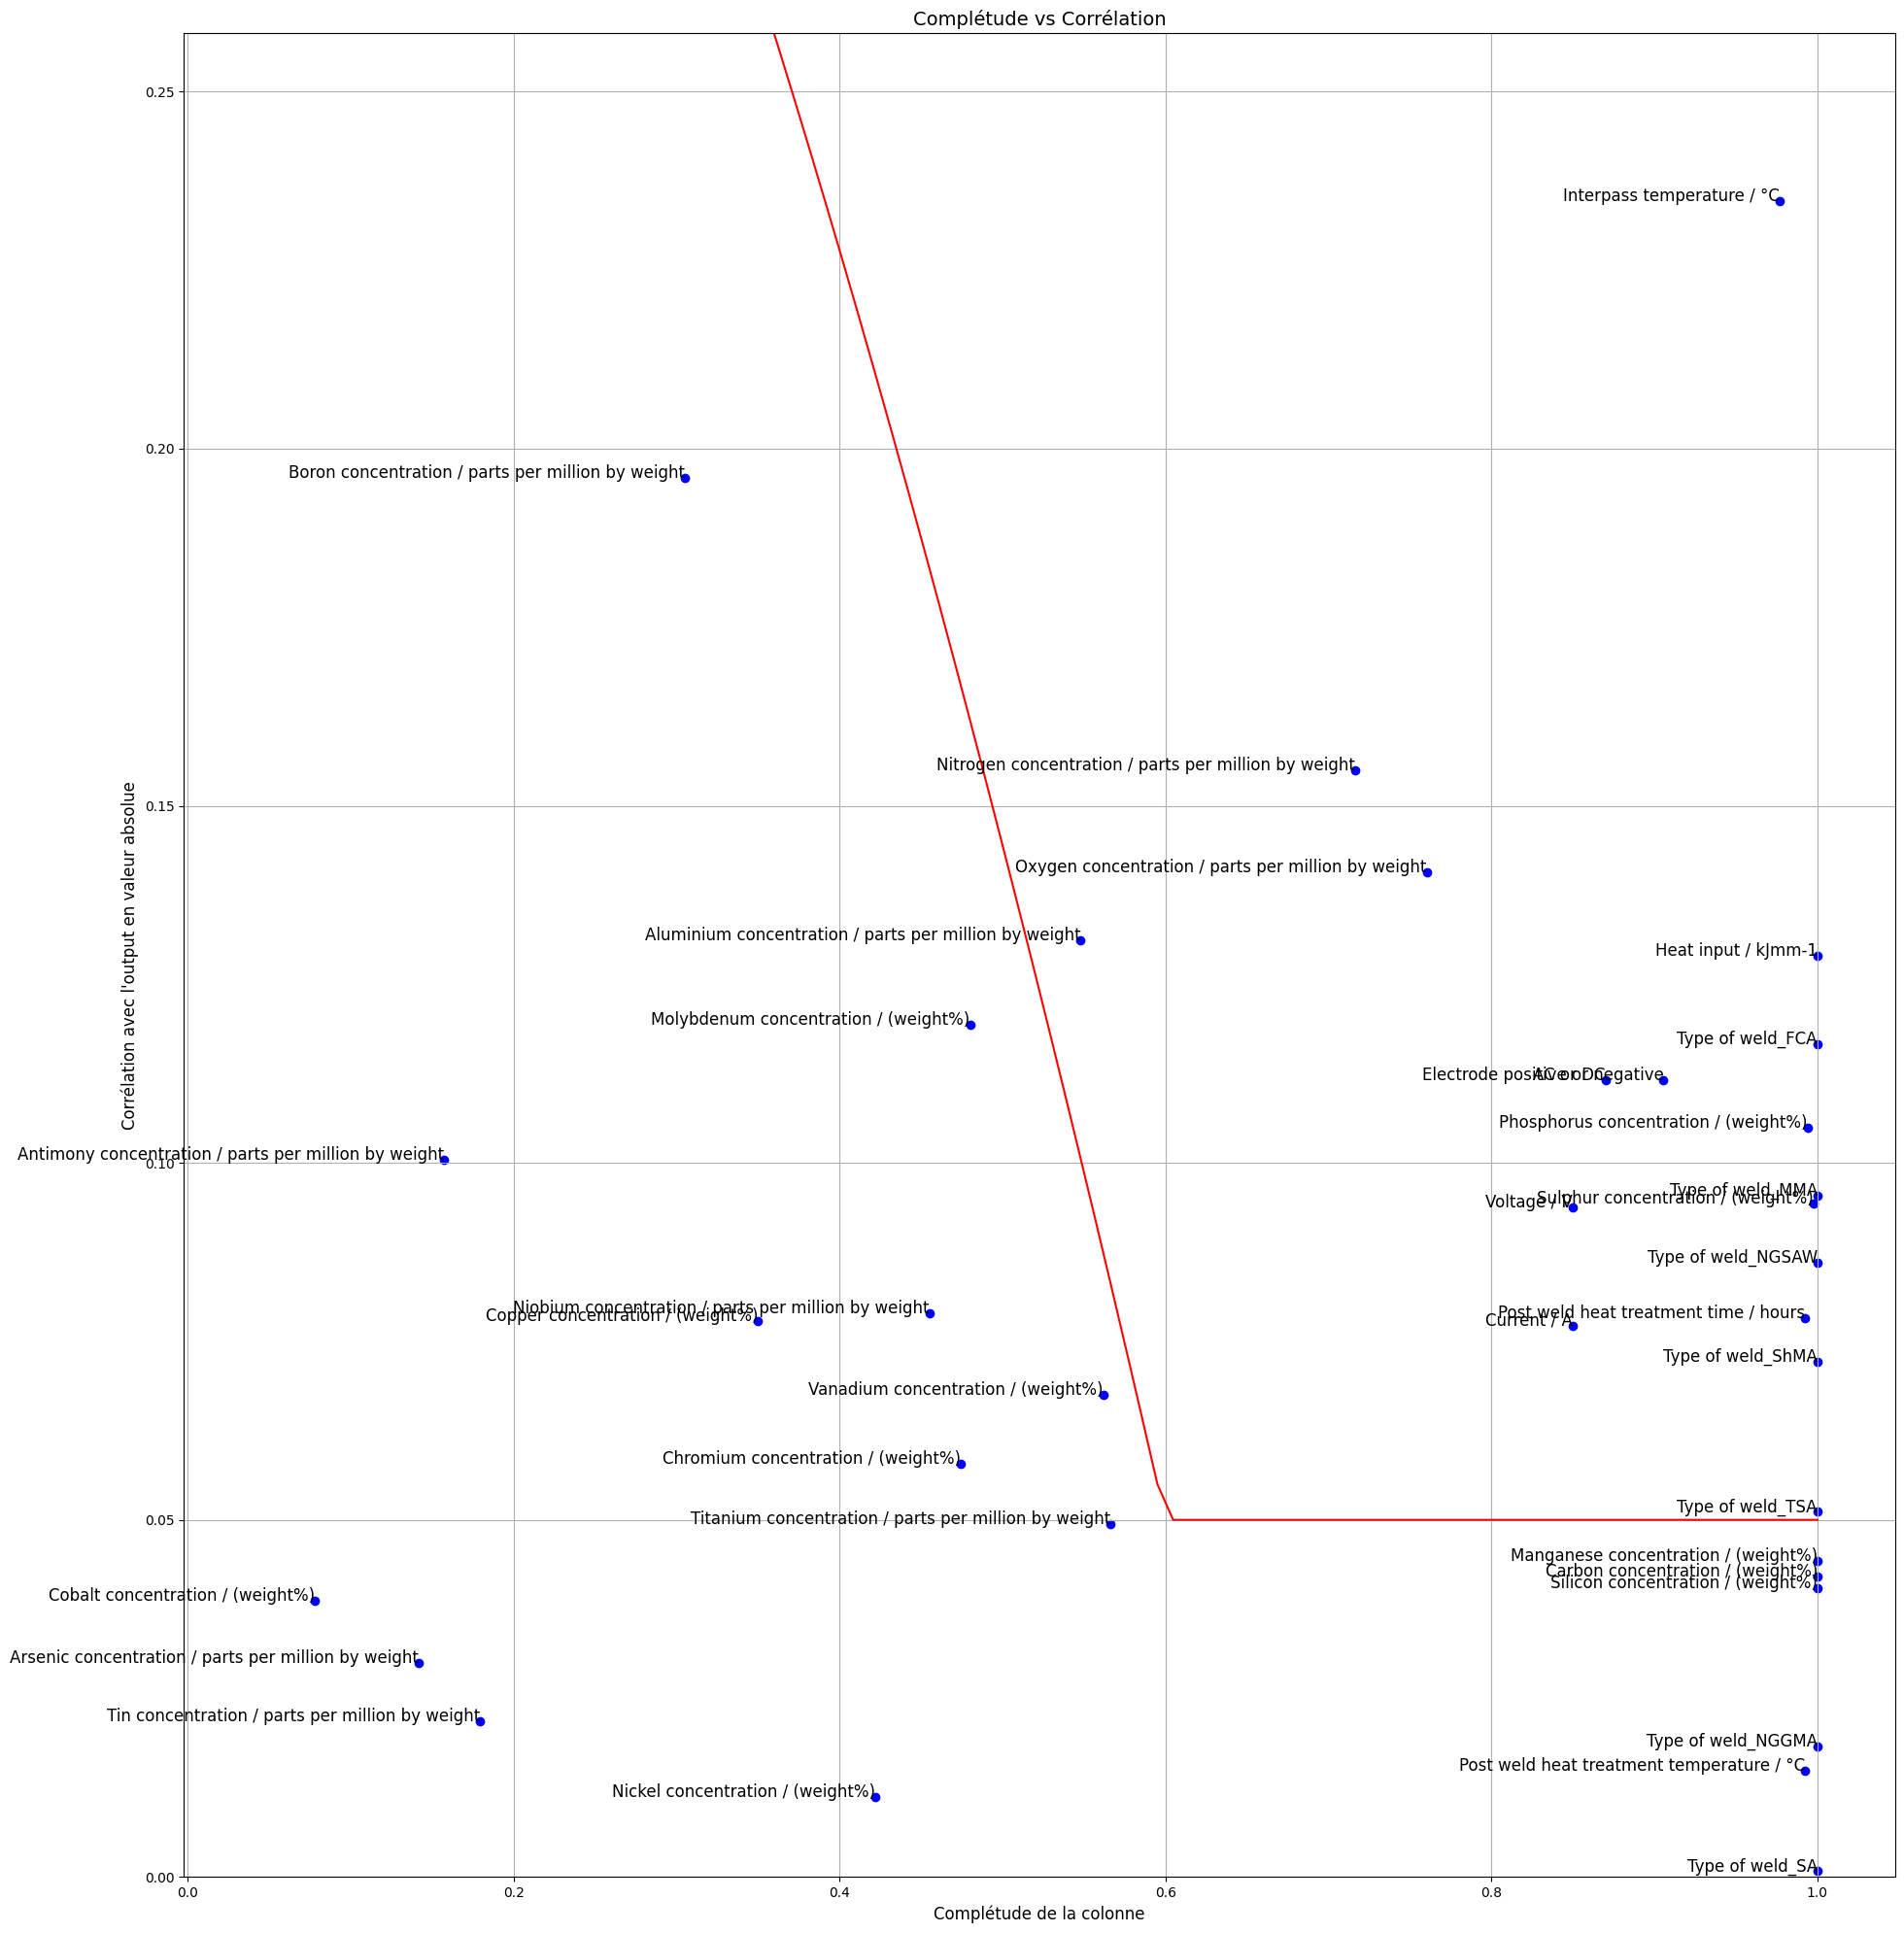

In [13]:
plot_completeness_vs_corr(Db, OutputColumn.ch_imp_toughness, feature_decision=feature_decision)

In [3]:
preprocessed_Db = preprocess_supervised(Db, output_col=OutputColumn.yield_strength, all_welds=False)
y=preprocessed_Db['output']
X=preprocessed_Db.drop('output', axis=1)

We retain only the rows with output values Yield strength / MPa, that is 47.215496% of the dataset


# PCA

In [4]:
from dataset_analysis.PCA import *

In [5]:
pca_datset=preprocess_PCA(Db)
pca_datset.describe()

,Chromium concentration / (weight%),Molybdenum concentration / (weight%),Titanium concentration / parts per million by weight,Vanadium concentration / (weight%),Cobalt concentration / (weight%),Boron concentration / parts per million by weight,Nickel concentration / (weight%),Interpass temperature / °C,Sulphur concentration / (weight%),Carbon concentration / (weight%),...,Nitrogen concentration / parts per million by weight,Copper concentration / (weight%),Post weld heat treatment time / hours,Voltage / V,Niobium concentration / parts per million by weight,Post weld heat treatment temperature / °C,Tin concentration / parts per million by weight,Current / A,Heat input / kJmm-1,Phosphorus concentration / (weight%)
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1.652000e+03,...,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1.652000e+03,1652.000000
mean,-0.190206,-0.365134,-0.124588,-0.022615,-1.065860,0.214289,0.209397,-0.013613,0.001245,4.129062e-16,...,-0.017548,-0.080523,-0.002702,-0.055869,-0.049562,-0.001987,-0.246519,-0.028192,3.440885e-17,0.006762
std,0.862470,0.970674,1.139174,0.982201,2.591625,1.036492,0.991459,1.003696,0.999515,1.000303e+00,...,0.955155,1.194388,0.999521,1.009195,0.887365,0.998154,1.149649,0.956304,1.000303e+00,1.002812
min,-2.209153,-3.097656,-5.775260,-3.263897,-18.066933,-7.498104,-2.486006,-4.676541,-0.796824,-1.947250e+00,...,-2.180444,-10.812907,-1.501237,-7.083032,-2.860019,-1.067493,-5.710894,-1.788775,-8.481709e-01,-0.558207
25%,-0.694724,-1.004277,-0.728901,-0.237711,-2.286954,-0.393843,-0.501782,-0.123999,-0.314099,-5.764332e-01,...,-0.457020,-0.533126,-0.828603,-0.526436,-0.569441,-1.067493,-0.468589,-0.591419,-5.400215e-01,-0.303376
50%,-0.378514,-0.617502,-0.379612,-0.206847,-0.735453,-0.066121,-0.118480,-0.123999,-0.225014,-6.368496e-02,...,-0.296036,-0.239104,-0.500421,-0.526436,-0.332009,-0.191563,-0.050191,-0.591419,-5.400215e-01,-0.150477
75%,0.065703,0.274783,0.350127,0.322583,-0.006196,0.783119,0.764851,-0.123999,0.042240,4.385990e-01,...,0.058707,0.408246,0.812308,0.190630,0.295136,0.964665,0.303479,0.083932,2.303519e-01,0.053387
max,2.920556,2.492730,6.287688,14.659838,22.357878,6.970965,3.922965,2.405191,11.623235,4.373157e+00,...,4.575533,4.517805,3.109584,3.804639,3.783926,1.595334,10.793449,3.200939,4.775555e+00,12.081401


In [6]:
pca, principal_components, nb_relevant_features = run_PCA(pca_datset)

In [18]:
pca_datset.columns

Index(['Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Titanium concentration / parts per million by weight',
       'Vanadium concentration / (weight%)',
       'Cobalt concentration / (weight%)',
       'Boron concentration / parts per million by weight',
       'Nickel concentration / (weight%)', 'Interpass temperature / °C',
       'Sulphur concentration / (weight%)', 'Carbon concentration / (weight%)',
       'Arsenic concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Oxygen concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight',
       'Manganese concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Silicon concentration / (weight%)',
       'Nitrogen concentration / parts per million by weight',
       'Copper concentration / (weight%)',
       'Post weld heat treatment time / hours', 'Volt

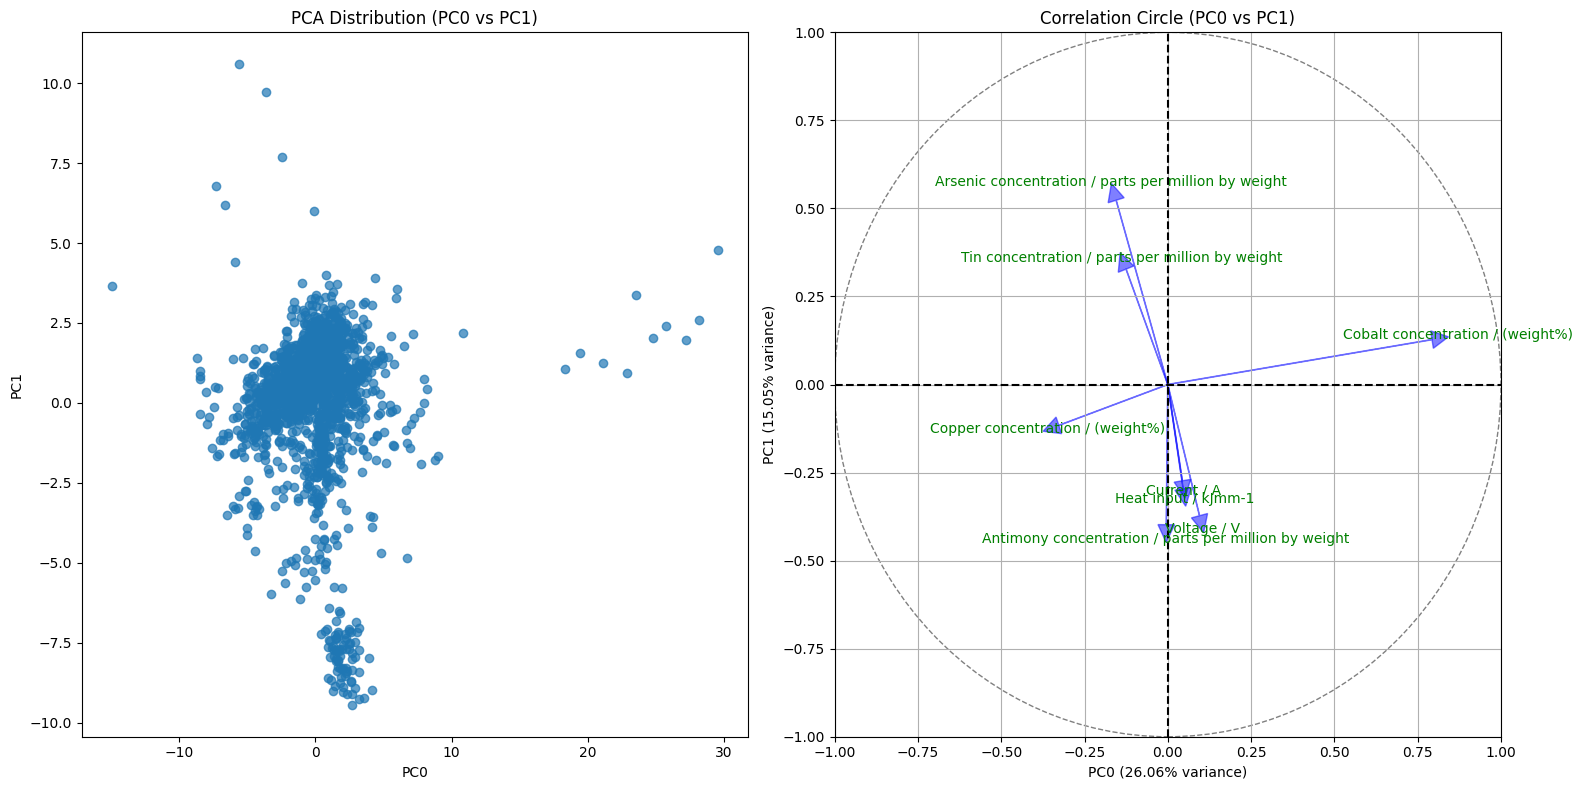

In [16]:
plot_PCA(pca, principal_components, 2, pca_datset.columns)

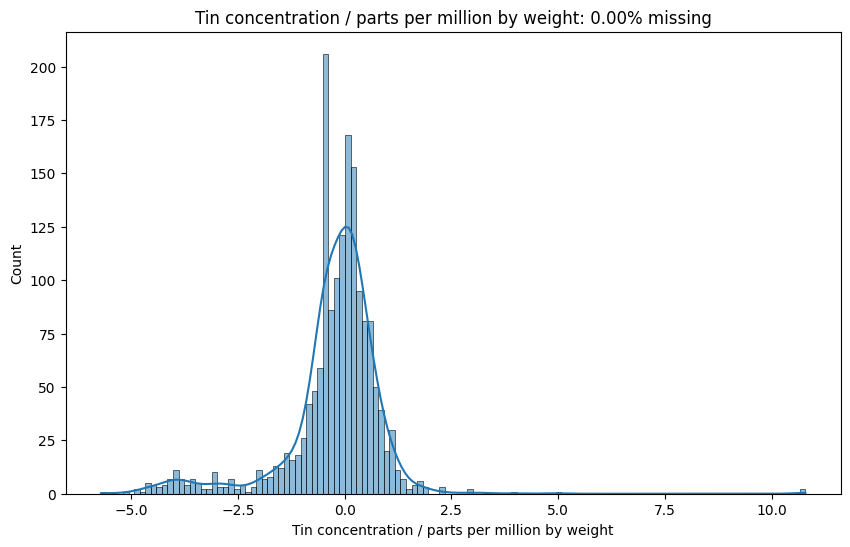

In [20]:
from plots import column_info
column_info('Cobalt concentration / (weight%)', Db)

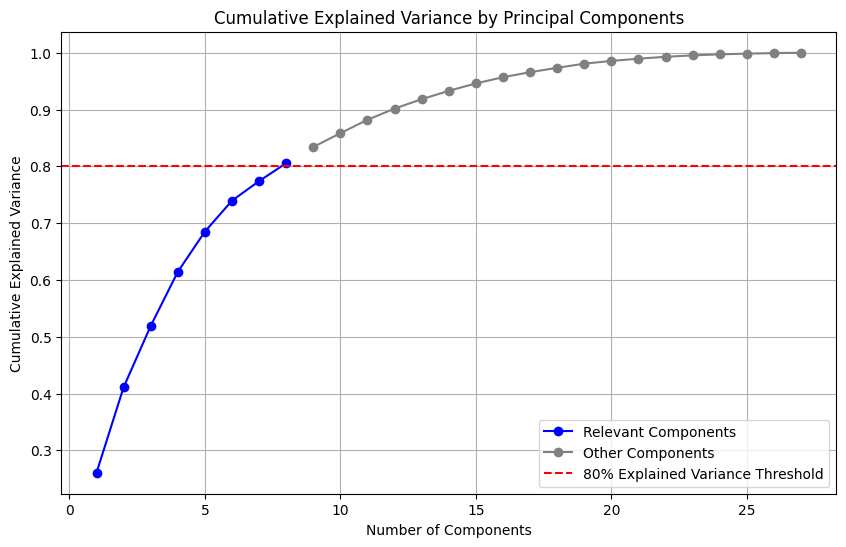

In [8]:

plot_explained_variance_pca(pca, nb_relevant_features)

# Semi supervised learning